In [1]:
# Base Data Science snippet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tqdm import tqdm_notebook

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch

In [5]:
import sys
sys.path.append("C:/git/case7-lockdown-exit-strategy")

from pyepidemics.models import SIR

# True model we want to estimate

In [6]:
N = 1e6
beta = 3.3/4
gamma = 1/4
sir = SIR(N,beta,gamma)

In [7]:
states = sir.solve(1)

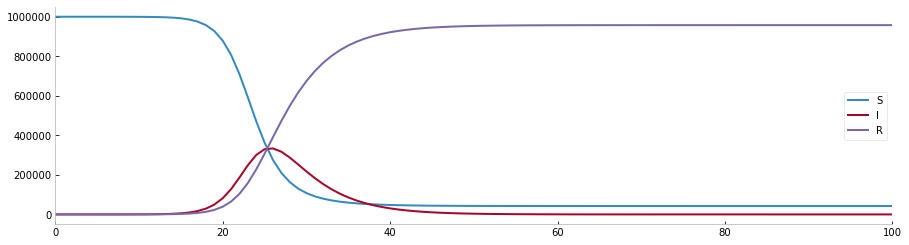

In [8]:
states.show(plotly = False)

# Pyro super-toy problem

## Find mu parameter of normal distribution
http://pyro.ai/examples/intro_part_i.html<br>
https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886<br>
http://pyro.ai/examples/svi_part_i.html<br>
https://forum.pyro.ai/t/need-help-with-very-simple-model/600<br>
http://willcrichton.net/notes/probabilistic-programming-under-the-hood/<br>

See also : 
- https://github.com/pyro-ppl/numpyro

In [9]:
import torch
import pyro.distributions as dist

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('1.3')
pyro.enable_validation(True)

Error to remember : 
- Don't put calls to params before SVI step
- Don't forget to clean the param_store
- Float arguments to params
- Use plate and not loops for data
- If invalid values in the optim with SVI -> decrease the learning rate

Questions
- Where is the prior ?
- How does it flow between guide and model ?
- MCMC and SVI ?

Next steps
- Empirical distributions (see also bayesian methods for hackers)
- MCMC / difference with HMC

In [10]:
N = 10000
mu_true = 3.3
mu_prior = -1
mu_prior2 = mu_prior
sigma_true = 1.1

dist_true = torch.distributions.Normal(mu_true,sigma_true)
data = dist_true.sample((N,))

In [11]:
def model2(data):
    mu = pyro.sample("mu", dist.Normal(3,1))
    for i in range(len(data)):
        pyro.sample(f"obs_{i}",dist.Normal(mu,sigma_true),obs = data[i])
        
def model(data):
    mu = pyro.sample("mu", dist.Normal(float(mu_prior),1))
    with pyro.plate("observed_data"):
        pyro.sample("obs",dist.Normal(mu,sigma_true),obs = data)

def guide(data):
    mu = pyro.param("mu0", torch.tensor(float(mu_prior2)))
    pyro.sample("mu",dist.Normal(mu,1))
    
print(pyro.get_param_store().get_all_param_names())

dict_keys([])


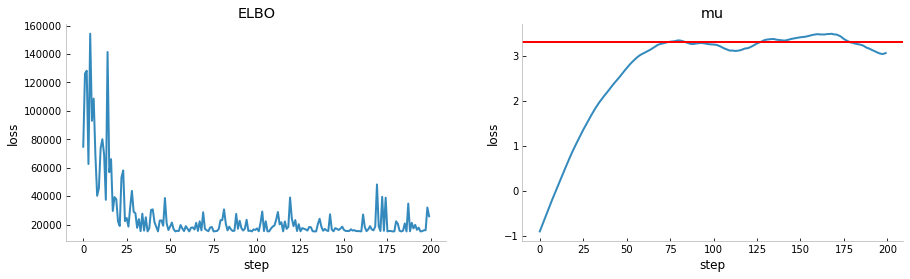

In [45]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
n_steps = 200
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("mu0")))
    
myfig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("loss")

plt.show()

## Find mu parameter with confidence

In [59]:
mu_std_prior = 3

In [60]:
def model(data):
    mu = pyro.sample("mu", dist.Normal(float(mu_prior),float(mu_std_prior)))
    with pyro.plate("observed_data"):
        pyro.sample("obs",dist.Normal(mu,sigma_true),obs = data)

def guide(data):
    mu_std = pyro.param("mu_std", torch.tensor(float(mu_std_prior)))
    mu_mu = pyro.param("mu_mu", torch.tensor(float(mu_prior2)))
    pyro.sample("mu",dist.Normal(mu_mu,mu_std))

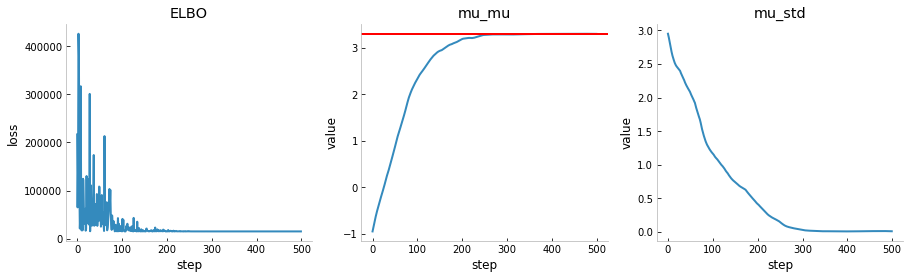

In [63]:
# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 500
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("mu_mu")))
    params_std.append(float(pyro.param("mu_std")))
    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()

## Find mu parameter with MCMC
##### References
- https://forum.pyro.ai/t/need-help-with-very-simple-model/600/7
- http://docs.pyro.ai/en/stable/mcmc.html
- http://docs.pyro.ai/en/stable/mcmc.html#hmc with [example](https://forum.pyro.ai/t/simple-mcmc-on-gamma-beta-providing-wrong-estimates/259/2)
- https://forum.pyro.ai/t/mcmc-linear-regression-very-low-variance/633
- http://pyro.ai/examples/bayesian_regression_ii.html

##### Also
- https://arviz-devs.github.io/arviz/ for visualization
- Emcee another library for MCMC https://emcee.readthedocs.io/en/stable/tutorials/line/

In [165]:
N = 1000
mu_true = 3.3
sigma_true = 1.1
mu_prior = 1
mu_std_prior = 4

dist_true = torch.distributions.Normal(mu_true,sigma_true)
data = dist_true.sample((N,))

In [100]:
from pyro.infer import MCMC, NUTS

def model(data):
    mu = pyro.sample("mu", dist.Normal(float(mu_prior),float(mu_std_prior)))
    with pyro.plate("observed_data"):
        pyro.sample("obs",dist.Normal(mu,sigma_true),obs = data)

In [101]:
nuts_kernel = NUTS(model, adapt_step_size=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300, num_chains=1)
mcmc_run = mcmc.run(data)
# posterior = pyro.infer.EmpiricalMarginal(mcmc_run, 'latent_mu0')

Sample: 100%|██████████████████████████████████████| 1300/1300 [00:10, 129.74it/s, step size=9.86e-01, acc. prob=0.922]


In [102]:
mcmc.summary(prob = 0.5)


                mean       std    median     25.0%     75.0%     n_eff     r_hat
        mu      3.33      0.03      3.32      3.30      3.34    308.29      1.00

Number of divergences: 0


# Bayesian SIR
- http://pyro.ai/examples/svi_part_i.html
- https://mltrain.cc/wp-content/uploads/2018/02/MLTrain@UAI_-Bayesian-Regression-in-Pyro.pdf
- https://medium.com/paper-club/understanding-pyros-model-and-guide-a-love-story-7f3aa0603886

## MCMC test

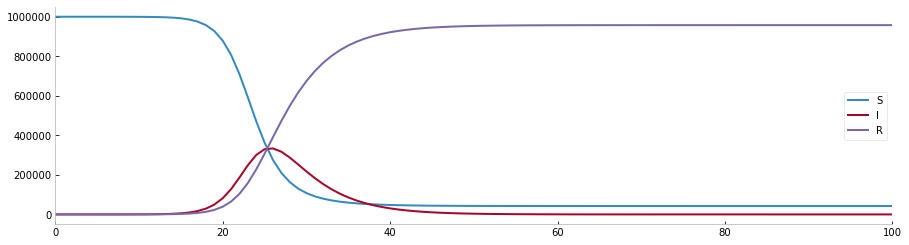

Wall time: 341 ms


In [14]:
%%time
N = 1e6
beta = 3.3/4
gamma = 1/4
sir = SIR(N,beta,gamma)
states = sir.solve(1)
states.show(plotly = False)
data = torch.Tensor(states["I"]) / N

In [205]:
def sample_result():
    R0 = pyro.sample("R0", dist.Normal(2, 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / N
    return pred


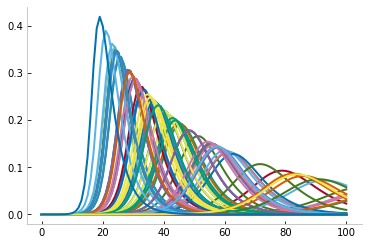

In [209]:
for i in range(100):
    plt.plot(sample_result())

In [210]:
def model(data):
    R0 = pyro.sample("R0", dist.Normal(2, 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / N
    sigma = torch.tensor(0.1)
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)

In [211]:
nuts_kernel = NUTS(model, adapt_step_size=True,jit_compile=False,adapt_mass_matrix=False,full_mass=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300, num_chains=1)
mcmc_run = mcmc.run(data)
# posterior = pyro.infer.EmpiricalMarginal(mcmc_run, 'latent_mu0')

Warmup:   0%|                                                                                   | 0/1300 [00:00, ?it/s]

KeyboardInterrupt: 

In [204]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0      2.03      1.00      2.03      0.26      3.51    357.28      1.00

Number of divergences: 0


## SVI test

### With autoguide

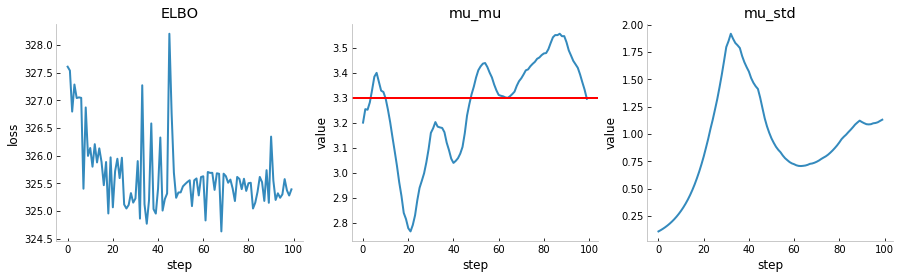

In [162]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

def model(data):
    R0 = pyro.sample("R0", dist.Normal(3.3, 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / N
    sigma = torch.tensor(20.)
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)
        

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 100
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("AutoMultivariateNormal.loc")))
    params_std.append(float(pyro.param("AutoMultivariateNormal.scale_tril")))

    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()

### Without autoguide

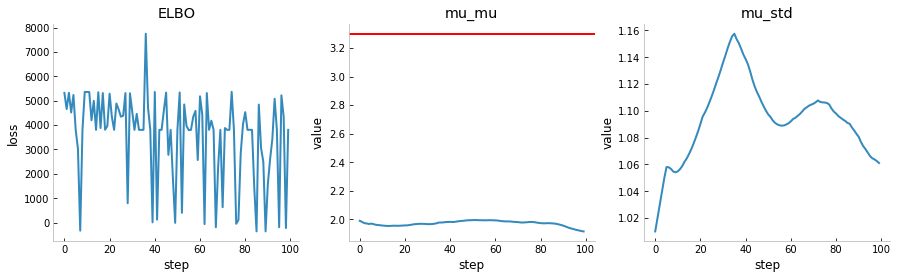

In [15]:
r0_prior = 2.0

def model(data):
    R0 = pyro.sample("R0", dist.Normal(float(r0_prior), 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / N
    sigma = torch.tensor(0.01)
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)
        
def guide(data):
    mu_mu = pyro.param("R0_mu", torch.tensor(float(r0_prior)))
    mu_std = pyro.param("R0_std", torch.tensor(float(1.0)))
    pyro.sample("R0",dist.Normal(mu_mu,mu_std))

# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 100
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("R0_mu")))
    params_std.append(float(pyro.param("R0_std")))

    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()

### With std normalization

In [34]:
data = sir.solve(1)["I"].values
data_std = np.std(data)
data = torch.Tensor((data - np.mean(data)) / np.std(data))

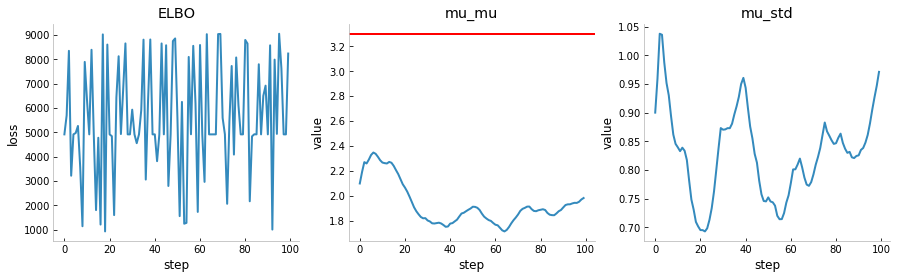

In [36]:
r0_prior = 2.0

def model(data):
    R0 = pyro.sample("R0", dist.Normal(float(r0_prior), 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / data_std
    sigma = torch.tensor(0.1)
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)
        
def guide(data):
    mu_mu = pyro.param("R0_mu", torch.tensor(float(r0_prior)))
    mu_std = pyro.param("R0_std", torch.tensor(float(1.0)))
    pyro.sample("R0",dist.Normal(mu_mu,mu_std))

# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 100
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("R0_mu")))
    params_std.append(float(pyro.param("R0_std")))

    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()

### With exponential sigma
http://pyro.ai/numpyro/bayesian_regression.html#Regression-Model-with-Measurement-Error

In [ ]:
sir.solve(1)

In [ ]:
r0_prior = 2.0

def model(data):
    R0 = pyro.sample("R0", dist.Normal(float(r0_prior), 1.0))
    sir = SIR(N,R0*gamma,gamma)
    pred = torch.Tensor(sir.solve(1)["I"]) / N
    sigma = pyro.sample('sigma', dist.Exponential(1.))
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)
        
def guide(data):
    mu_mu = pyro.param("R0_mu", torch.tensor(float(r0_prior)))
    mu_std = pyro.param("R0_std", torch.tensor(float(1.0)))
    pyro.sample("R0",dist.Normal(mu_mu,mu_std))

# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.01}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 100
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(data))
    params.append(float(pyro.param("R0_mu")))
    params_std.append(float(pyro.param("R0_std")))

    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()

# Bayesian Curve fitting

In [51]:
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import torch

from pyro.infer import MCMC, NUTS

In [52]:
def logistic_fn(X, c, k, m):
    y = c / (1 + np.exp(-k*(X-m)))
    return y

def gaussian_fn(X, a, mu, sigma):
    y = a * np.exp(-0.5 * ((X-mu)/sigma)**2)
    return y

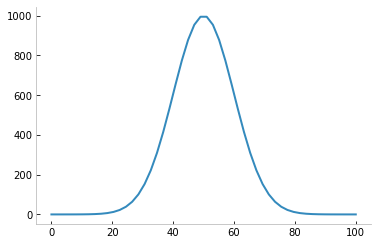

In [68]:
x = np.linspace(0,100)
y = torch.Tensor(gaussian_fn(x,1000,50,10))
plt.plot(x,y);

In [70]:
mu_prior = 30

def model(data):
    mu = pyro.sample("mu", dist.Normal(float(mu_prior), 10.0))
    pred = torch.Tensor(gaussian_fn(x,1000,float(mu),10))
    sigma = pyro.sample('sigma', dist.Exponential(1.))
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)

        
nuts_kernel = NUTS(model, adapt_step_size=True,jit_compile=False,adapt_mass_matrix=False,full_mass=True)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300, num_chains=1)
mcmc_run = mcmc.run(y)
# posterior = pyro.infer.EmpiricalMarginal(mcmc_run, 'latent_mu0')

Warmup:  19%|███████▌                                | 246/1300 [03:51,  1.83s/it, step size=1.68e-05, acc. prob=0.788]

KeyboardInterrupt: 

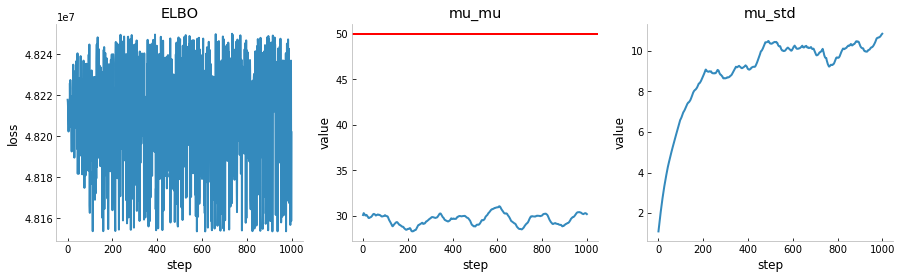

In [82]:
mu_prior = 30
mu_true = 50

def model(data):
    mu = pyro.sample("mu", dist.Normal(float(mu_prior), 10.0))
    pred = torch.Tensor(gaussian_fn(x,1000,float(mu),10)) / 1000
    sigma = torch.tensor(0.3)
    with pyro.plate("obs"):
        pyro.sample("obs",dist.Normal(pred,sigma),obs = data)
        


def guide(data):
    mu_mu = pyro.param("mu_mu", torch.tensor(float(mu_prior)))
    mu_std = pyro.param("mu_std", torch.tensor(float(1.0)))
    pyro.sample("mu",dist.Normal(mu_mu,mu_std))


# clear the param store in case we're in a REPL
pyro.clear_param_store()

adam_params = {"lr": 0.1}
optimizer = Adam(adam_params)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


losses = []
params = []
params_std = []
n_steps = 1000
for step in tqdm_notebook(range(n_steps)):
    losses.append(svi.step(y))
    params.append(float(pyro.param("mu_mu")))
    params_std.append(float(pyro.param("mu_std")))

    
myfig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3,figsize = (15,4))
ax1.plot(losses)
ax1.set_title("ELBO")
ax1.set_xlabel("step")
ax1.set_ylabel("loss")

ax2.plot(params)
ax2.set_title("mu_mu")
ax2.axhline(mu_true,c = "red")
ax2.set_xlabel("step")
ax2.set_ylabel("value")

ax3.plot(params_std)
ax3.set_title("mu_std")
ax3.set_xlabel("step")
ax3.set_ylabel("value")

plt.show()